# Using the Taylor Expansion to Calculate Finite Differences in Python

This Jupyter Notebook is an extension of the [write-up I had provided for the MVMT SCI website](https://mvmtsci.com/using-the-taylor-expansion-to-calculate-finite-differences-in-python). Now that we've gone through the math, let's pick back up where we left off and check out the code in action!

In [1]:
import numpy as np
from math import pi
from math import sqrt
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

 The code I've written to compute the coefficients is as follows:

In [2]:
def get_finite_difference_coefficients(d, order_accuracy):
        '''
        Compute the coefficients for the finite difference equation corresponding to the derivative, d, to a 
        specified order of accuracy.
        

        Parameters
        -----------------
        d: int
            The derivative in which we are approximating (e.g. 1st, 2nd, 3rd, etc.).
        
        order_accuracy: int
            The order of accuracy in which the finite difference equation will approximate to. This must be a
            multiple of 2 for the symmetric difference.

        Returns
        -----------------

        coefficients: numpy.ndarray
            The coefficients used in the finite difference equation to approximate the derivative.
        '''
        # N number of coefficients
        # The if statement below is used to ensure that the correct order accuracy is specified and to raise an
        # appropriate error if not specified.
        if order_accuracy % 2 == 0:
            if d % 2 == 0:
                N = d + order_accuracy - 1
            else:
                N = d + order_accuracy
        else:
            raise ValueError('Order of Accuracy must be a multiple of 2 for the symmetric difference')
        
        # n represents the number of coefficients pre and post the frame of interest. This is used to create a
        # vector "master_row" below.
        n = np.int((N-1)/2)

        master_row = np.arange(n * -1, n + 1)
        # Creating an NxN matrix as a placeholder (note that the matrix indices shown in (6) start at 0 and end
        # at N-1, so its dimension is NxN).
        matrix = np.zeros([len(master_row), len(master_row)])
        
        # This loop raises each element of master_row to the exponent i. As noted in the previous text, there is 
        # a pattern in which the center of the rows are always =0, and each number to the right corresponds to +1,
        # +2, +3... etc. and to the left corresponds to -1, -2, -3,... etc. Calculating the matrix of the 
        # constants from the Taylor Expansion is therefore as simple as raising the elements in master_row to the 
        # exponent of the row number (i.e. the index of the for loop).
        for i in range(len(master_row)):
            matrix[i] = master_row ** i
        
        # Create a dummy vector named 'vec' to ultimately hold the right-hand side of our system of equations.
        vec = np.zeros(len(master_row))
        np.put(vec, d, np.math.factorial(d))
        # As shown above, our coefficients are then calculated by solving the system of linear equations in the
        # standard manner.
        coefficients = np.matmul(np.linalg.inv(matrix), vec)
            
        
        ## Uncommenting the code below will add a tolerance to force what "should be" zero values to return as 0.
        ## If uncommenting, you can adjust the tolerance to whatever you feel may be more appropriate.
        
        #tolerance = 1e-10
        #coefficients[abs(coefficients.real) < tolerance] = 0

        return coefficients

Testing this function to approximate the first derivative with an order of accuracy = 2 yields the coefficients:

In [3]:
get_finite_difference_coefficients(d=1,order_accuracy=2)

array([-0.5,  0. ,  0.5])

Which corresponds to the coefficients from [(2) (Section 1)](https://mvmtsci.com/using-the-taylor-expansion-to-calculate-finite-differences-in-python).

Similarly, if we compute the first derivative with an order of accuracy =4, the coefficients are:

In [4]:
get_finite_difference_coefficients(d=1,order_accuracy=4)

array([ 8.33333333e-02, -6.66666667e-01, -2.37904934e-16,  6.66666667e-01,
       -8.33333333e-02])

Which corresponds to [(4) (Section 1)](https://mvmtsci.com/using-the-taylor-expansion-to-calculate-finite-differences-in-python). Note that computers are limited in their precision and the coefficient that _should_ correspond to $0$ is actually $-2.37904934e^{-16}$. Although this isn't exactly $0$, it's close enough it won't make much of a difference in most practical scenarios. I have added some code (commented-out) that could force values under a certain tolerance to $0$, but I haven't found it to make much of a practical difference as there are still rounding errors in all the other coefficients that we aren't able to "clean up" as easily and there will always be growing trunkation errors as we approximate higher and higher derivatives.

Moving forward, let's now verify [the example where we computed the coefficients for the finite difference equation for the fourth derivative using 5 points (i.e. 2 pre and post)](https://mvmtsci.com/using-the-taylor-expansion-to-calculate-finite-differences-in-python):

In [5]:
get_finite_difference_coefficients(d=4,order_accuracy=2)

array([ 1., -4.,  6., -4.,  1.])

Which verifies our manual calculations from before.

Now, for fun, what if we were computing the 20th derivative using the 6th order of accuracy (i.e. 12 points pre and post the frame of interest)?

In [6]:
get_finite_difference_coefficients(d=20, order_accuracy=6)

array([ 2.42541945e-03, -2.29075785e-02,  4.90685567e-02,  2.29687820e-01,
       -1.01197773e+00, -3.79430110e+00,  4.42330884e+01, -1.87564512e+02,
        4.97701937e+02, -9.23710746e+02,  1.23066005e+03, -1.13603521e+03,
        5.93487692e+02,  9.84925072e+01, -5.43813938e+02,  5.90004457e+02,
       -3.87525350e+02,  1.67974204e+02, -4.45356553e+01,  4.23557379e+00,
        1.39859978e+00, -4.77579293e-01,  7.18401936e-03,  1.81578585e-02,
       -2.45265156e-03])

Those would be the coefficients. As you can see, the flexibility for approximating derivatives is quite large when we write an algorithm in this manner (however, as we will also see in future sections, the higher derivatives with this algorithm result in much more error due to rounding and trunkation errors).

## 2.2 Approximating the Derivative

The meat and potatoes are now complete. Now that we have a function that provides us with the necessary coefficients, we just need to simply write a function that "implements" it. I'm sure this can be improved on, but this is what I have written for now:

In [7]:
def compute_derivative(signal, t, d, order_accuracy=2):
    '''
    Compute the derivative, d,  of a signal over a constant time/sampling interval, t, using n points prior to
    and following the frame of interest.


    Parameters
    -----------------
    signal: array_like
        an array of the signal.

    t: float
        The time interval between samples (over a vector of timestamps, it is sufficient to input t[1] -t[0]).
        Alternatively, 1/sampling frequency can also be used to denote t.

    d: int
        The derivative to take of the signal.
    
    order_accuracy: int
        The order of accuracy in which the finite difference equation will approximate to. Default = 2

    Returns
    -----------------

    signal_: ndarray
        the nth derivative of the input signal. The length of the signal is equal to that of the intput signal.
        Note: NaN values are added at beginning and/or the end of the array when insufficient data is present
        to compute the derivative (e.g. first frame of data has no prior datapoint, and thus the first n frames
        will be NaN when selecting the symmetric difference)
    '''
    # Similar to the previous function, this is just to catch any potential input errors.
    if order_accuracy % 2 == 0:
        if d % 2 == 0:
            N = d + order_accuracy - 1
        else:
            N = d + order_accuracy
    else:
        raise ValueError('Order of Accuracy must be a multiple of 2 for the symmetric difference')
         
    n = np.int((N-1)/2)
    
    # Get the appropriate coefficients using the function specified above.
    coefficients = get_finite_difference_coefficients(d,order_accuracy)
    
    # Create an empty array that will contain the approximated derivatives as we loop through the input signal.
    derivative = np.array([])
    
    # Specify frames of data to be used for for loop (i.e. where to apply each coefficient)
    coefficient_num = len(np.arange(n * -1, n + 1))
    
    for i in range(len(signal)):
        if i < n:
            signal_prime = np.nan
        elif i >= len(signal) - n:
            signal_prime = np.nan
        else:
            # "Refresh" the signal_prime value which will be appended to the derivative vector following each loop.
            signal_prime = 0
            for c in range(coefficient_num):
                signal_prime += coefficients[c] * signal[i + c - n] / (t ** d)

        derivative = np.append(derivative, signal_prime)

    return derivative

I've written it so that the endpoints are removed (i.e. replaced with NaN) instead of quantified using different orders of accuracy or using forward and backward difference methods. This is something that could be easily changed in the future, but I just wanted to get a general sense of how the function was working currently. Also, Visual3D will output velocity, acceleration, etc. data with endpoints removed so I don't think this is too atypical from how software in the field currently works anyways.

# 3. Testing with Predictable Signals

Now, let's test how this function works. I'll provide the derivative of various sine and cosine signals since we know that the fourth derivative of $f(x)= cos(x)$ should be equal to itself, making it a good candidate to "test" the function's accuracy. Of course, in most exercise science applications we won't go much beyond the 3rd or 4th derivative, but I wanted to be explicit with how "accurate" this function is in practice.

For the plot labels, I am going to switch from Lagrange's notation ($f^{'}(x)$) to Leibniz's notation ($\frac{df}{dt}$) as it is neater to keep track of higher derivatives this way.

In [8]:
# Creating data to test function
x= np.linspace(0,8*pi, 100)
y= np.cos(x)

Text(0.5, 1.0, 'Approximated $\\dfrac{d^4f}{dt^4}$ From Python Function')

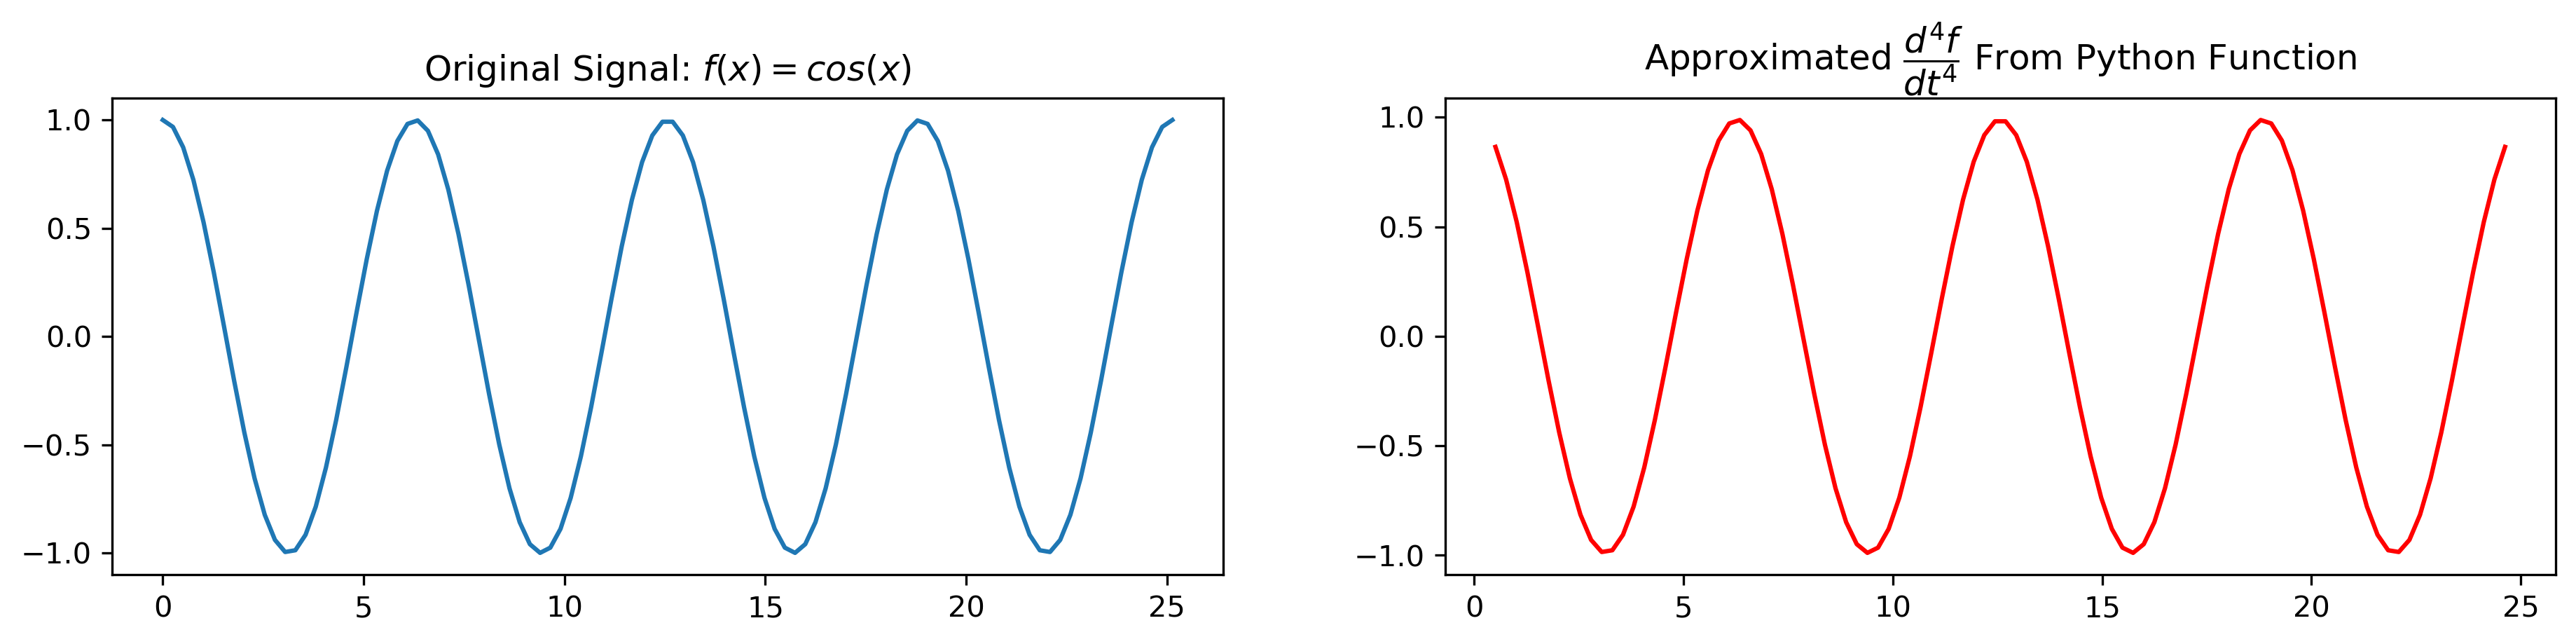

In [9]:
# Remember, the default order of accuracy = 2, so by not specifying it explicitly the derivative will be
# approximated to an order of accuracy of 2.
y_prime4 = compute_derivative(y,x[1]-x[0],d=4)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime4, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^4f}{dt^4}$ From Python Function')

Fourth derivative looks pretty good. What if we try the 8th derivative:

Text(0.5, 1.0, 'Approximated $\\dfrac{d^8f}{dt^8}$ From Python Function')

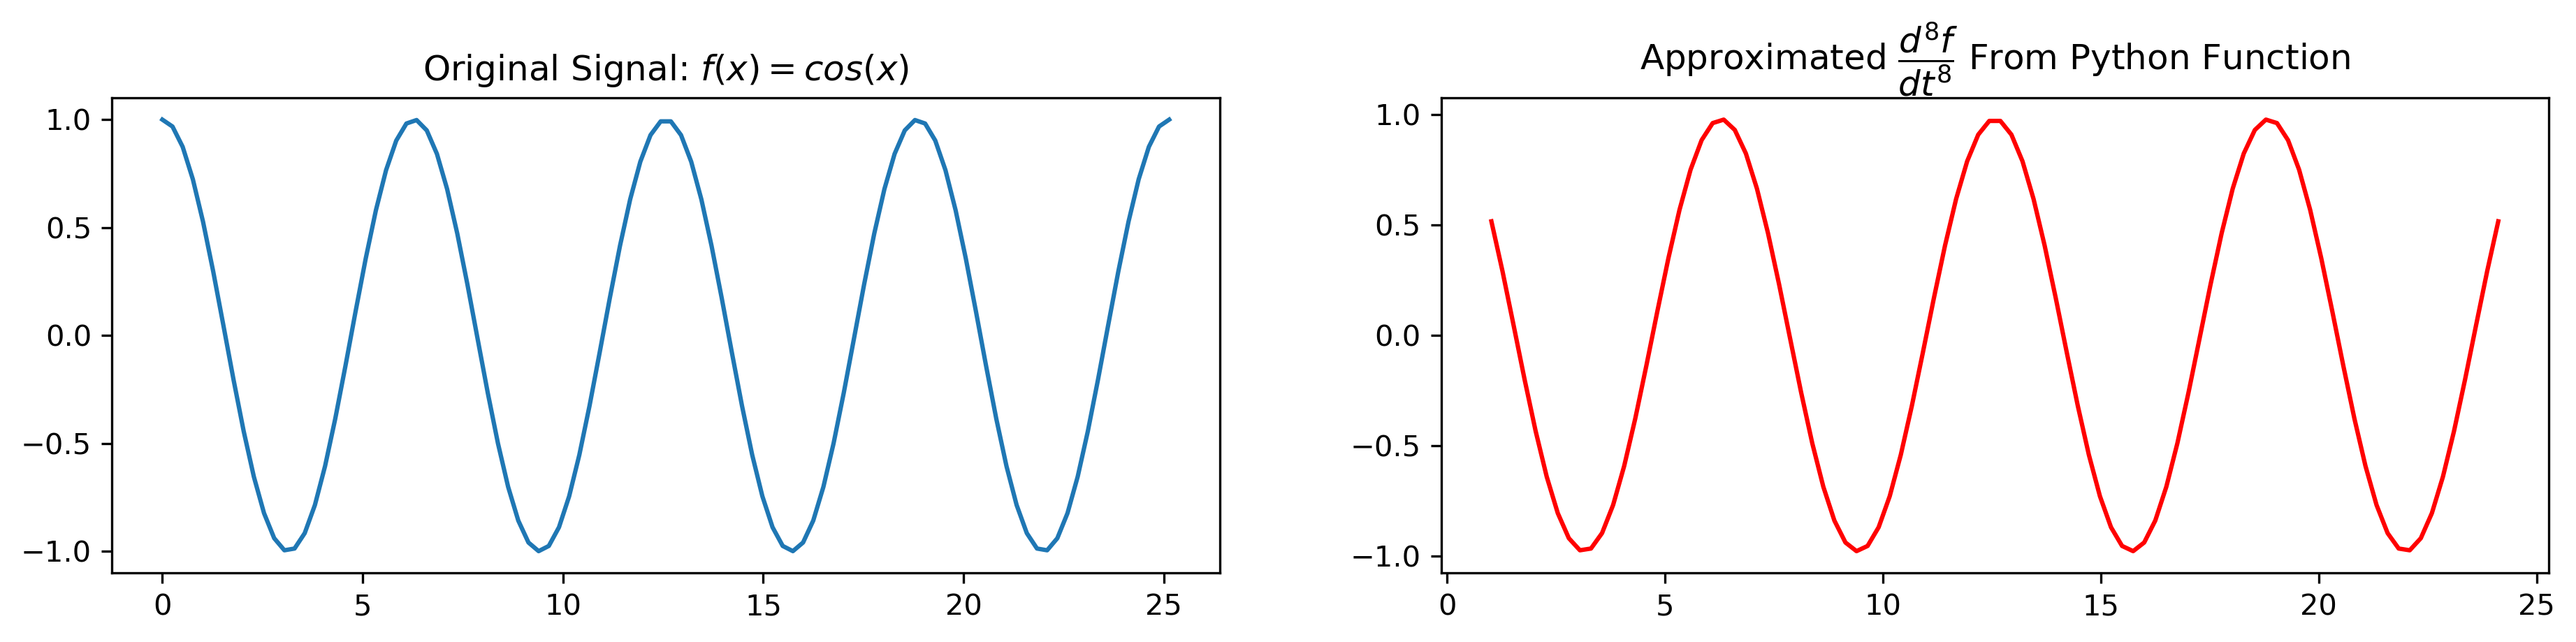

In [10]:
y_prime8 = compute_derivative(y,x[1]-x[0],d=8)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime8, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^8f}{dt^8}$ From Python Function')

Other than losing more endpoints because of the increased number of data points required to compute such a high derivative (and the way that I've written the function for now), it still looks pretty accurate up to the 8th derivative. What about the 12th?

Text(0.5, 1.0, 'Approximated $\\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

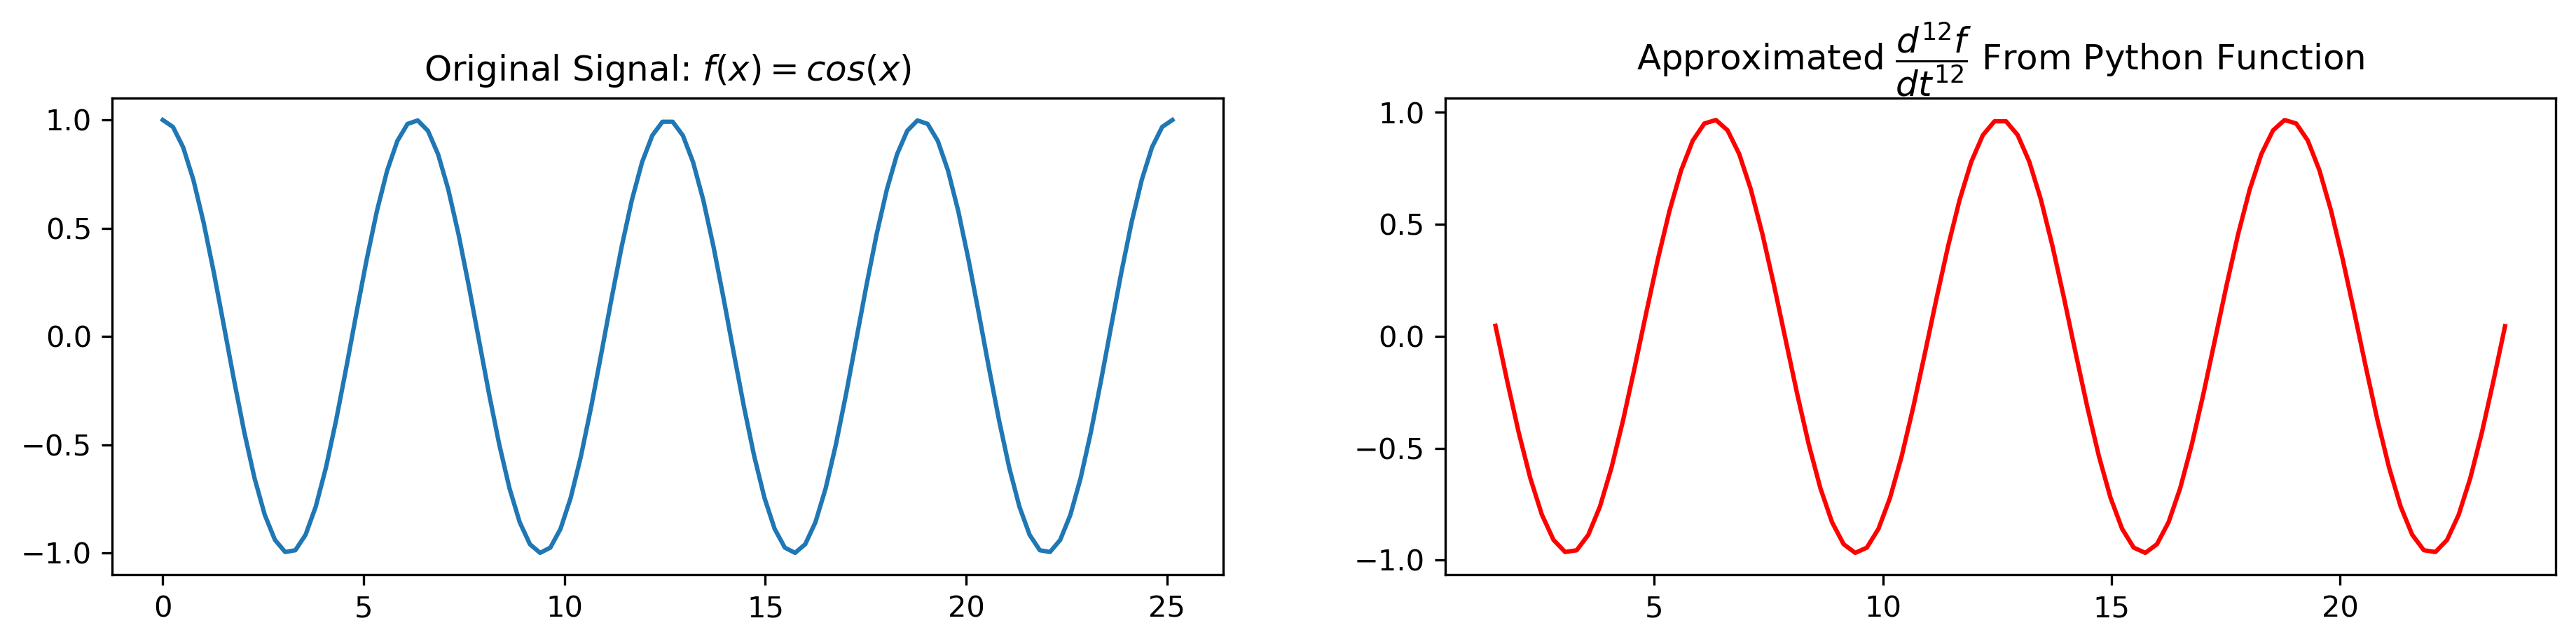

In [11]:
y_prime12 = compute_derivative(y,x[1]-x[0],d=12)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime12, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

Again, other than losing more datapoints, still pretty good. However, check out the Appendix for some odd subtleties to understand when the function "breaks down" (spoiler: after about the 13th derivative it starts to fall apart).

Although perhaps overkill at this point, let's just look at something a little more funky to see how the Python function handles approximating the 1st derivative compared to the known derivative using two different orders of accuracy:

Text(0.5, 1.0, 'Approximated $\\dfrac{df}{dt}$ From Python Function, Order of Accuracy = 6')

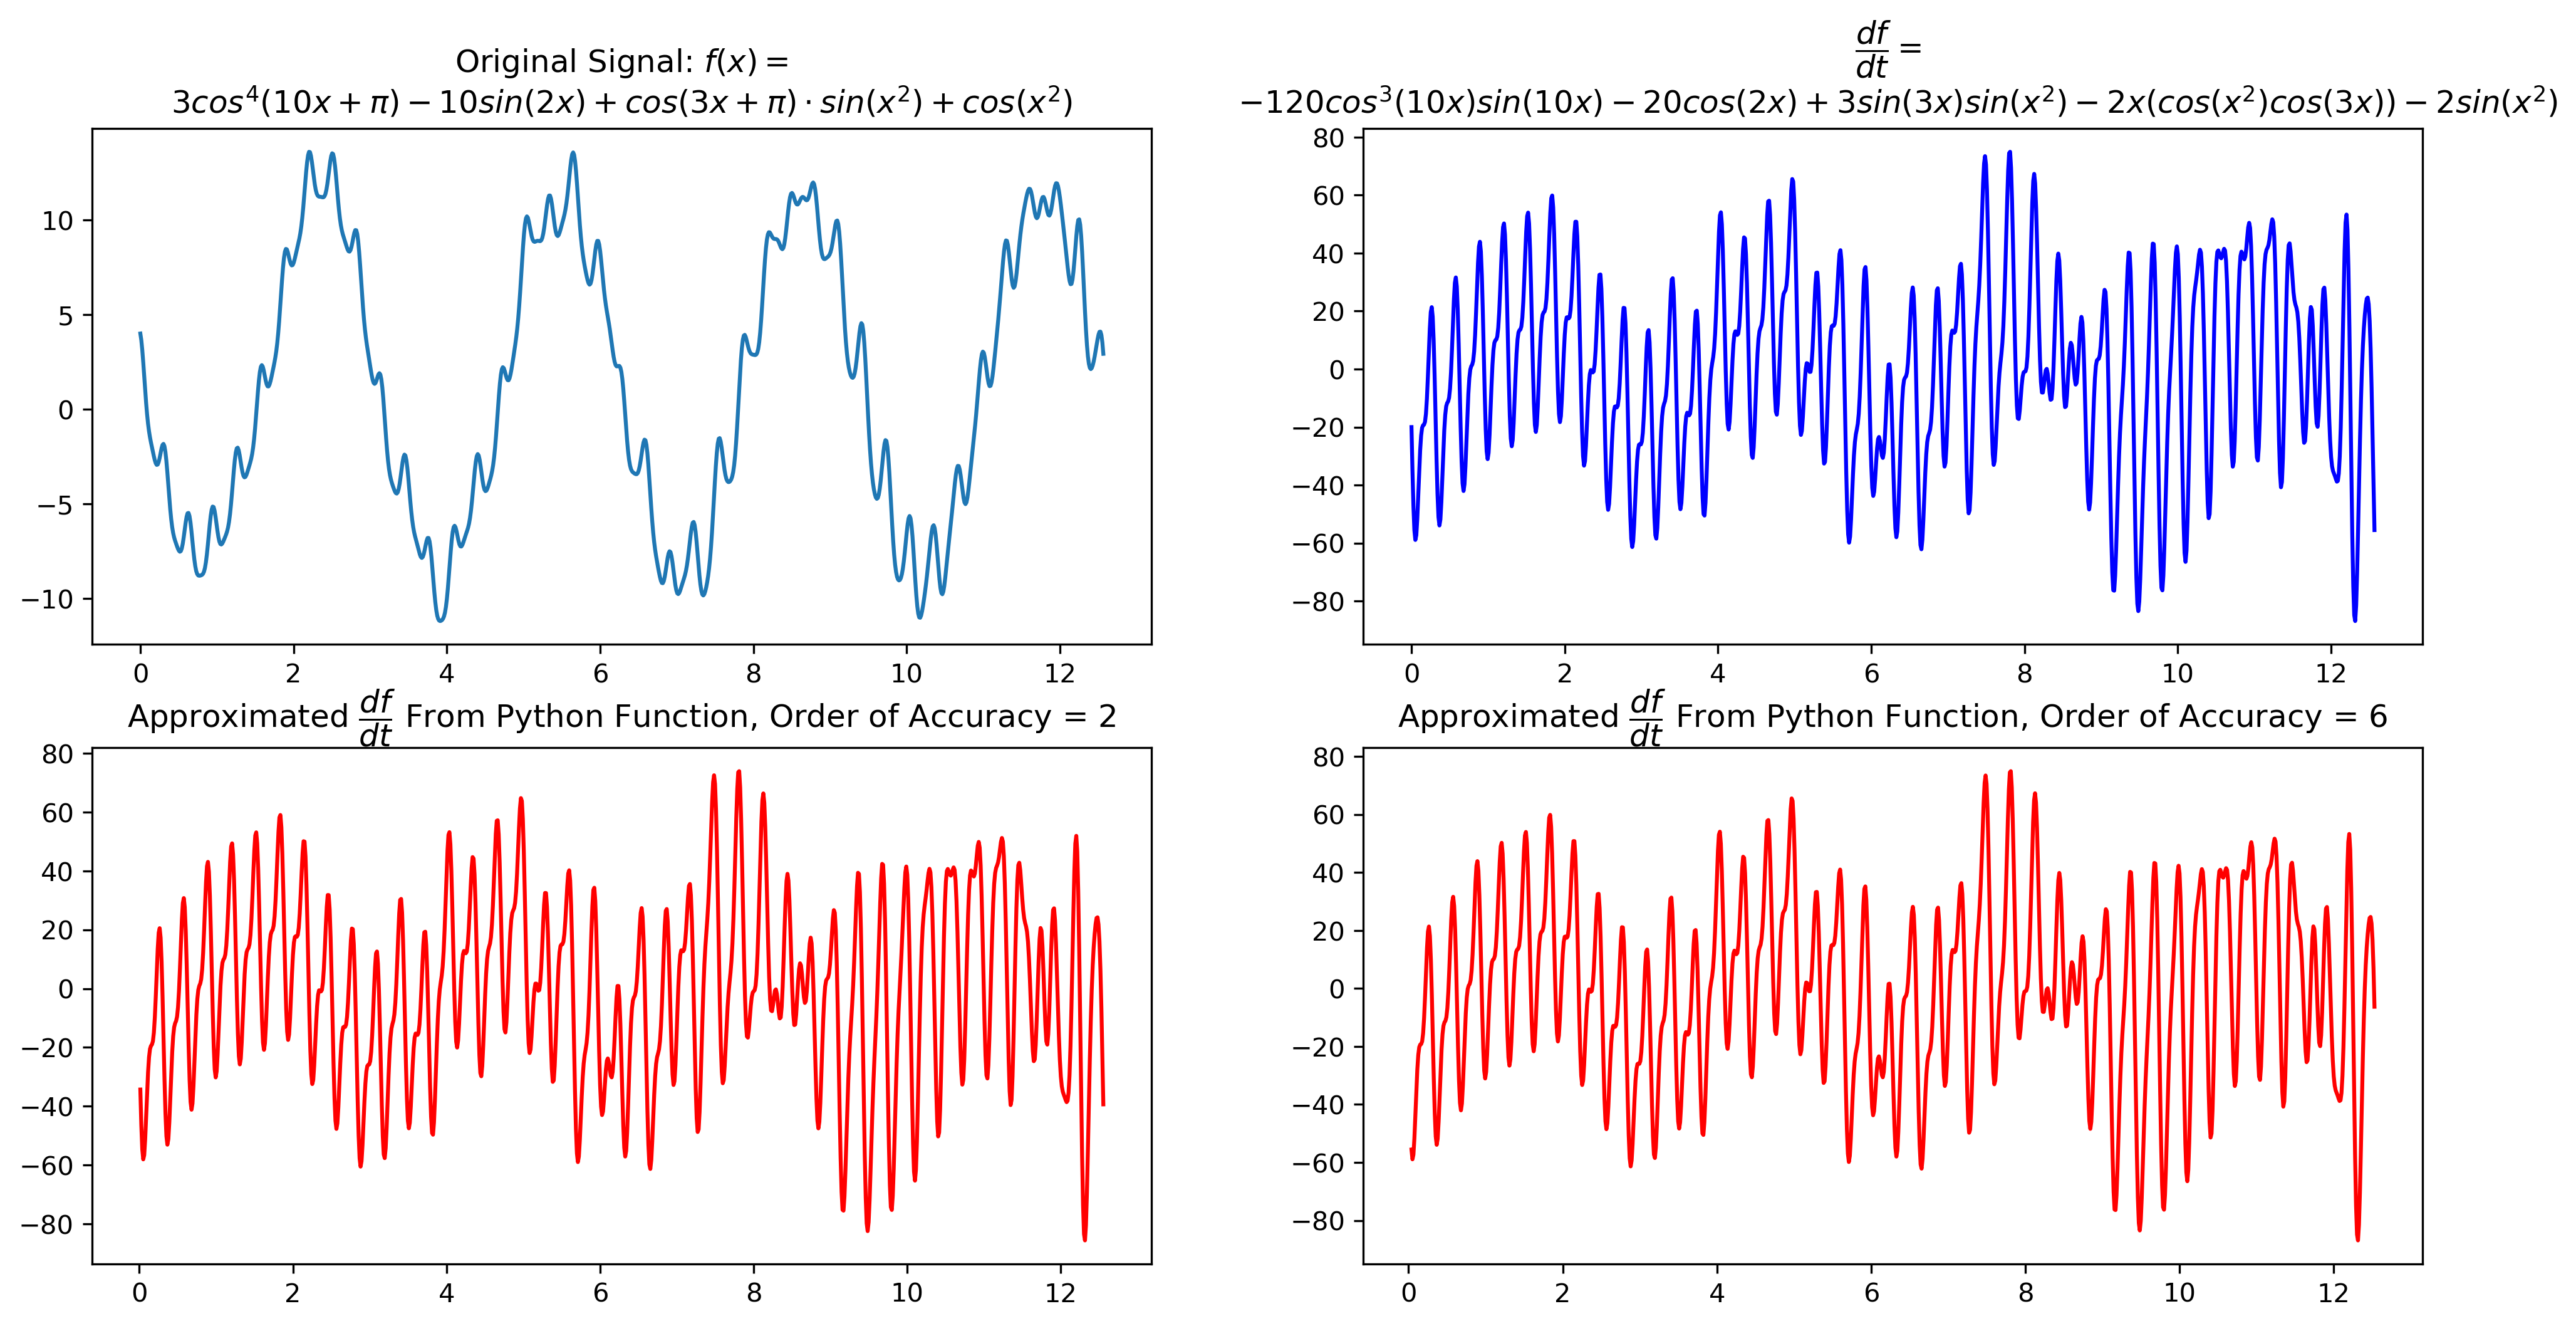

In [12]:
x= np.linspace(0,4*pi, 1000)
y_crazy= 3*np.cos(10*x+pi)**4 + -10*np.sin(2*x)+ np.cos(3*x + pi)*np.sin(x**2) + np.cos(x**2)
y_handDerivative = lambda x: -120*np.cos(10*x)**3*np.sin(10*x) + -20*np.cos(2*x) + 3*np.sin(3*x)*np.sin(x**2) - 2*x*np.cos(x**2)*np.cos(3*x) - 2*x*np.sin(x**2)
y_crazy_prime_approximate_2 = compute_derivative(y_crazy,x[1]-x[0],d=1)
y_crazy_prime_approximate_6 = compute_derivative(y_crazy,x[1]-x[0],d=1, order_accuracy=6)
y_crazy_prime_actual = y_handDerivative(x)
fig, ax = plt.subplots(2,2, figsize= (16,8))
ax[0,0].plot(x,y_crazy)
ax[0,0].set_title('Original Signal: $f(x)=$\n$3cos^4(10x+\pi) - 10sin(2x) + cos(3x+\pi)\cdot sin(x^2) + cos(x^2)$')
ax[0,1].plot(x, y_crazy_prime_actual, color='b')
ax[0,1].set_title("$\dfrac{df}{dt}=$ \n $-120cos^3(10x)sin(10x) - 20cos(2x) + 3sin(3x)sin(x^2) - 2x(cos(x^2)cos(3x)) - 2sin(x^2)$")
ax[1,0].plot(x,y_crazy_prime_approximate_2, color= 'r')
ax[1,0].set_title(r'Approximated $\dfrac{df}{dt}$ From Python Function, Order of Accuracy = 2')
ax[1,1].plot(x,y_crazy_prime_approximate_6, color= 'r')
ax[1,1].set_title(r'Approximated $\dfrac{df}{dt}$ From Python Function, Order of Accuracy = 6')

As you can see visually, the function provides a pretty good approximation to the actual derivative, regardless of the order of accuracy (as would be expected).

# 4. Conclusion

In summary, we started with a basic exercise seen in introductory biomechanics lessons using time-series data and a finite difference equation. We then expanded upon this equation to generalize it to higher derivatives and specify the order of accuracy using the Taylor Expansion. Then, we took this math and applied it to write some Python code  that can approximate derivatives of single-dimension data. There are probably cleaner ways to go about writing the code (as I am far from an expert in this space myself), but hopefully there is enough there to give you a general idea how it works and to give you something that you can use with your own data as well. Finally, I hope you learned something form this and it prompts you to continue exploring numerical analysis techniques for the future (I know it did for me)!

# 5. Appendix

As mentioned in Section 3, here is the "weirdness" I've stumbled upon. Let's take the twelfth derivative again, but experiment using a greater or fewer number points (i.e. higher or lower sampling frequencies) and cycles: 

Text(0.5, 1.0, 'Approximated $\\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

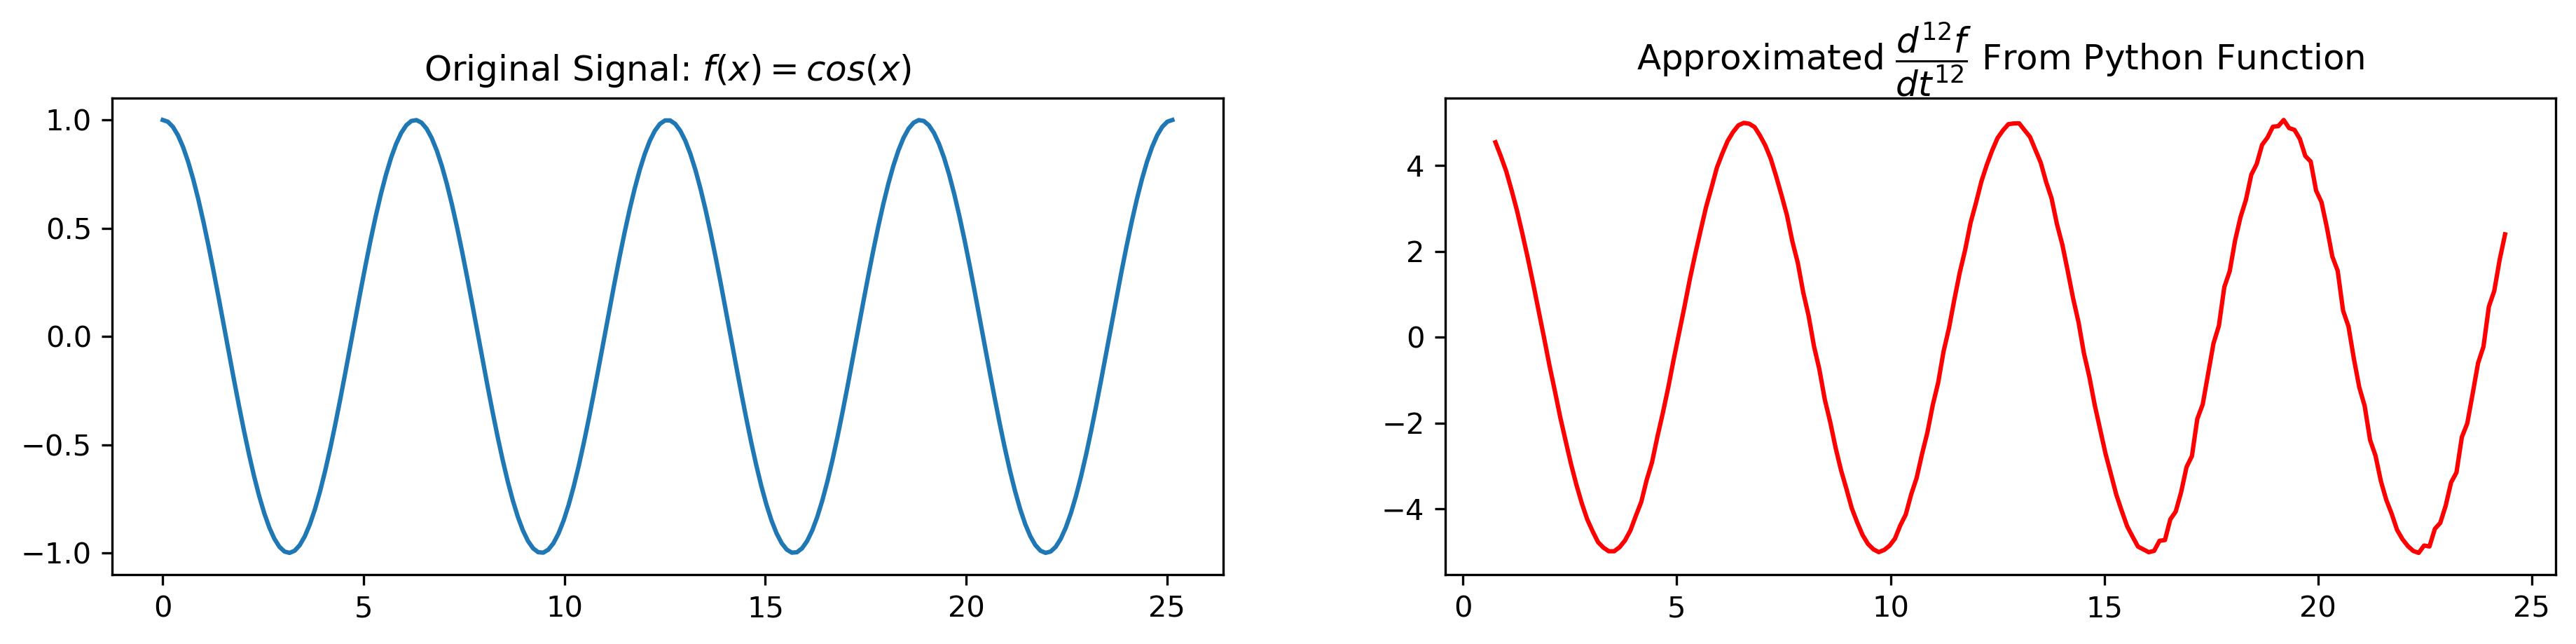

In [13]:
num_cycles=4
x= np.linspace(0,2*pi*num_cycles, 200)
y= np.cos(x)
y_prime12 = compute_derivative(y,x[1]-x[0],12,2)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime12, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

Text(0.5, 1.0, 'Approximated $\\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

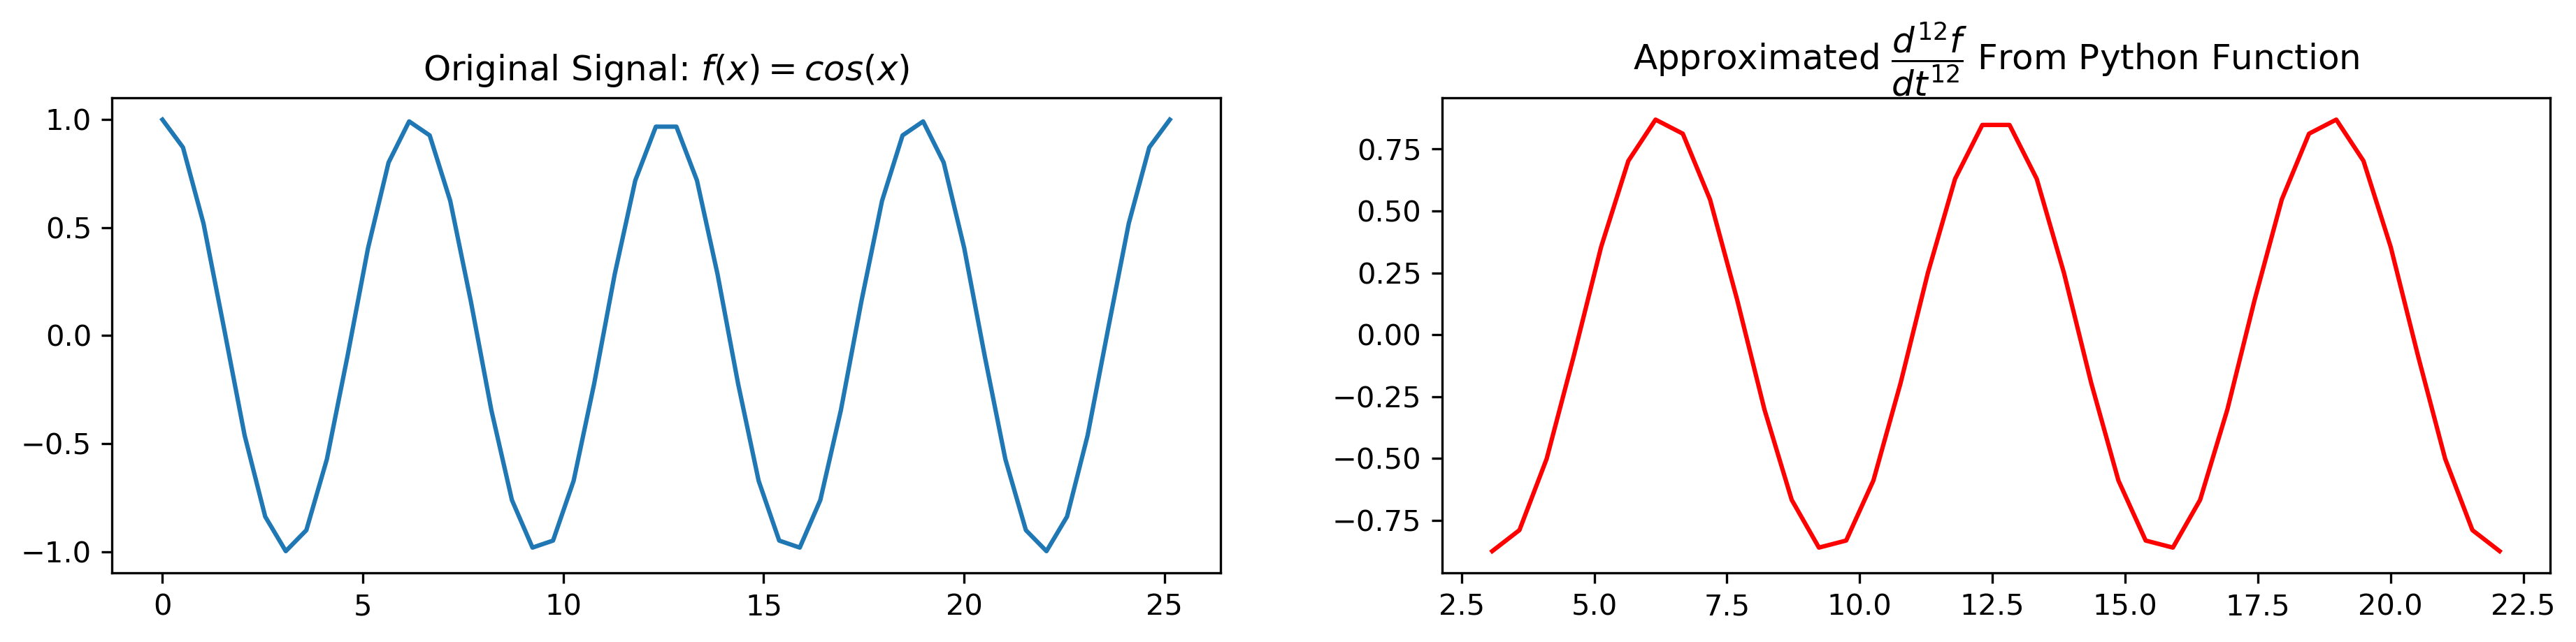

In [14]:
num_cycles= 4
x= np.linspace(0,2*pi*num_cycles, 50)
y= np.cos(x)
y_prime12 = compute_derivative(y,x[1]-x[0],12,2)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime12, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

Text(0.5, 1.0, 'Approximated $\\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

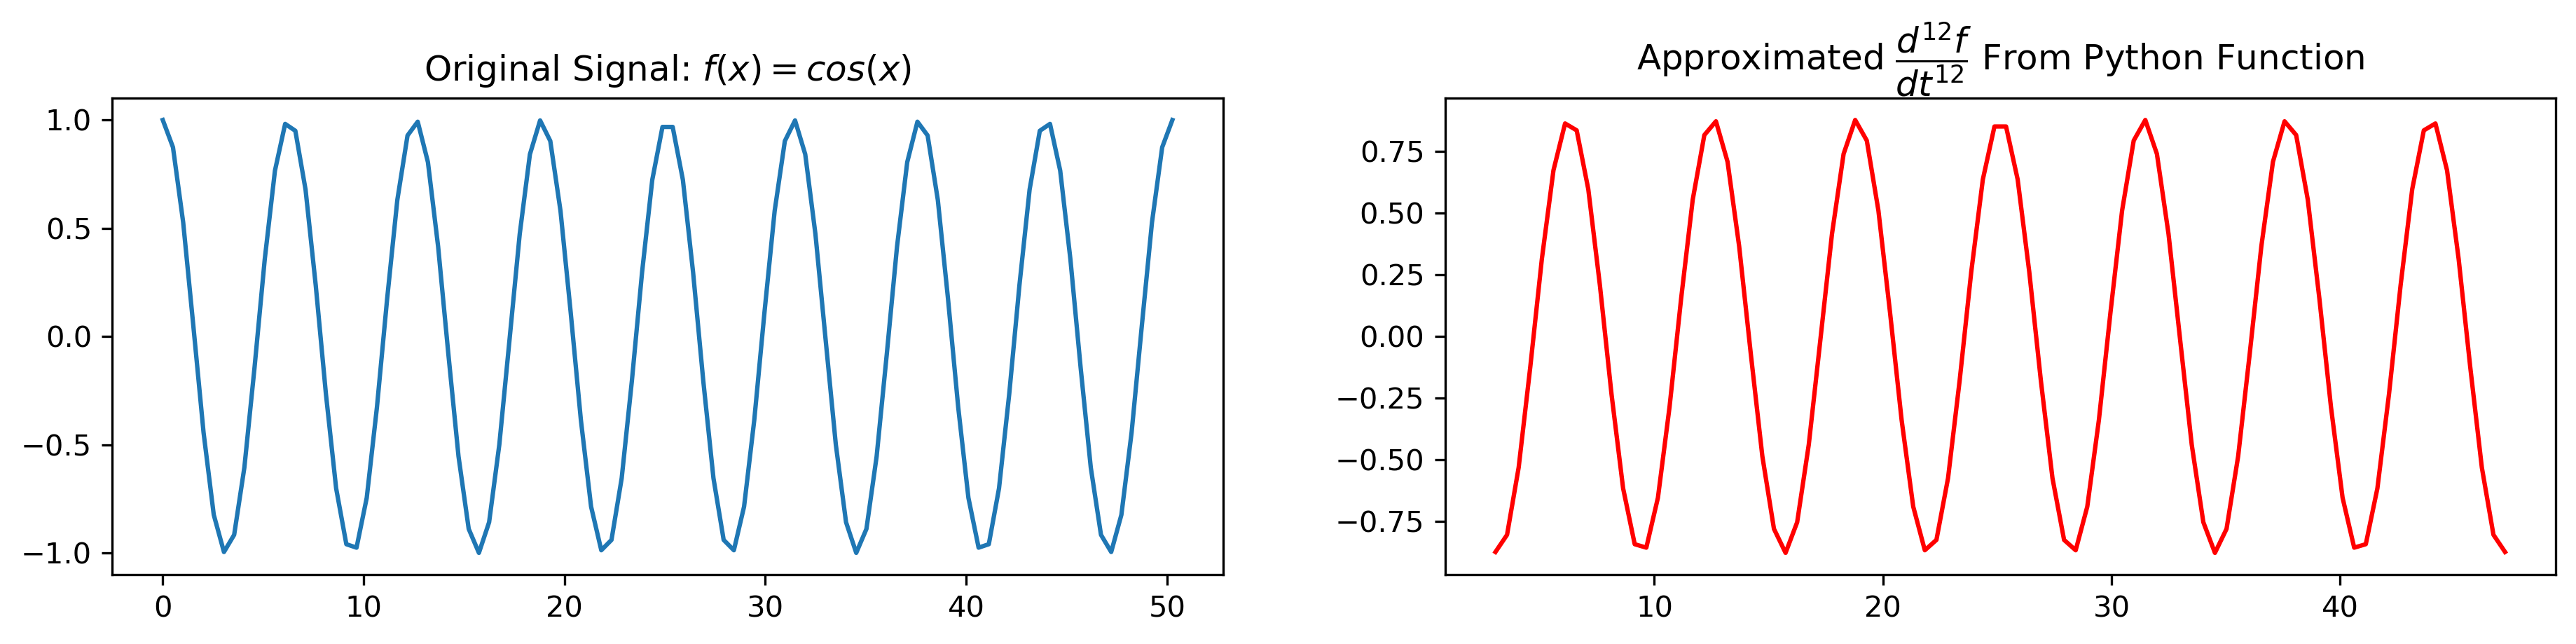

In [15]:
num_cycles= 8
x= np.linspace(0,2*pi*num_cycles, 100)
y= np.cos(x)
y_prime12 = compute_derivative(y,x[1]-x[0],12,2)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime12, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

Text(0.5, 1.0, 'Approximated $\\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

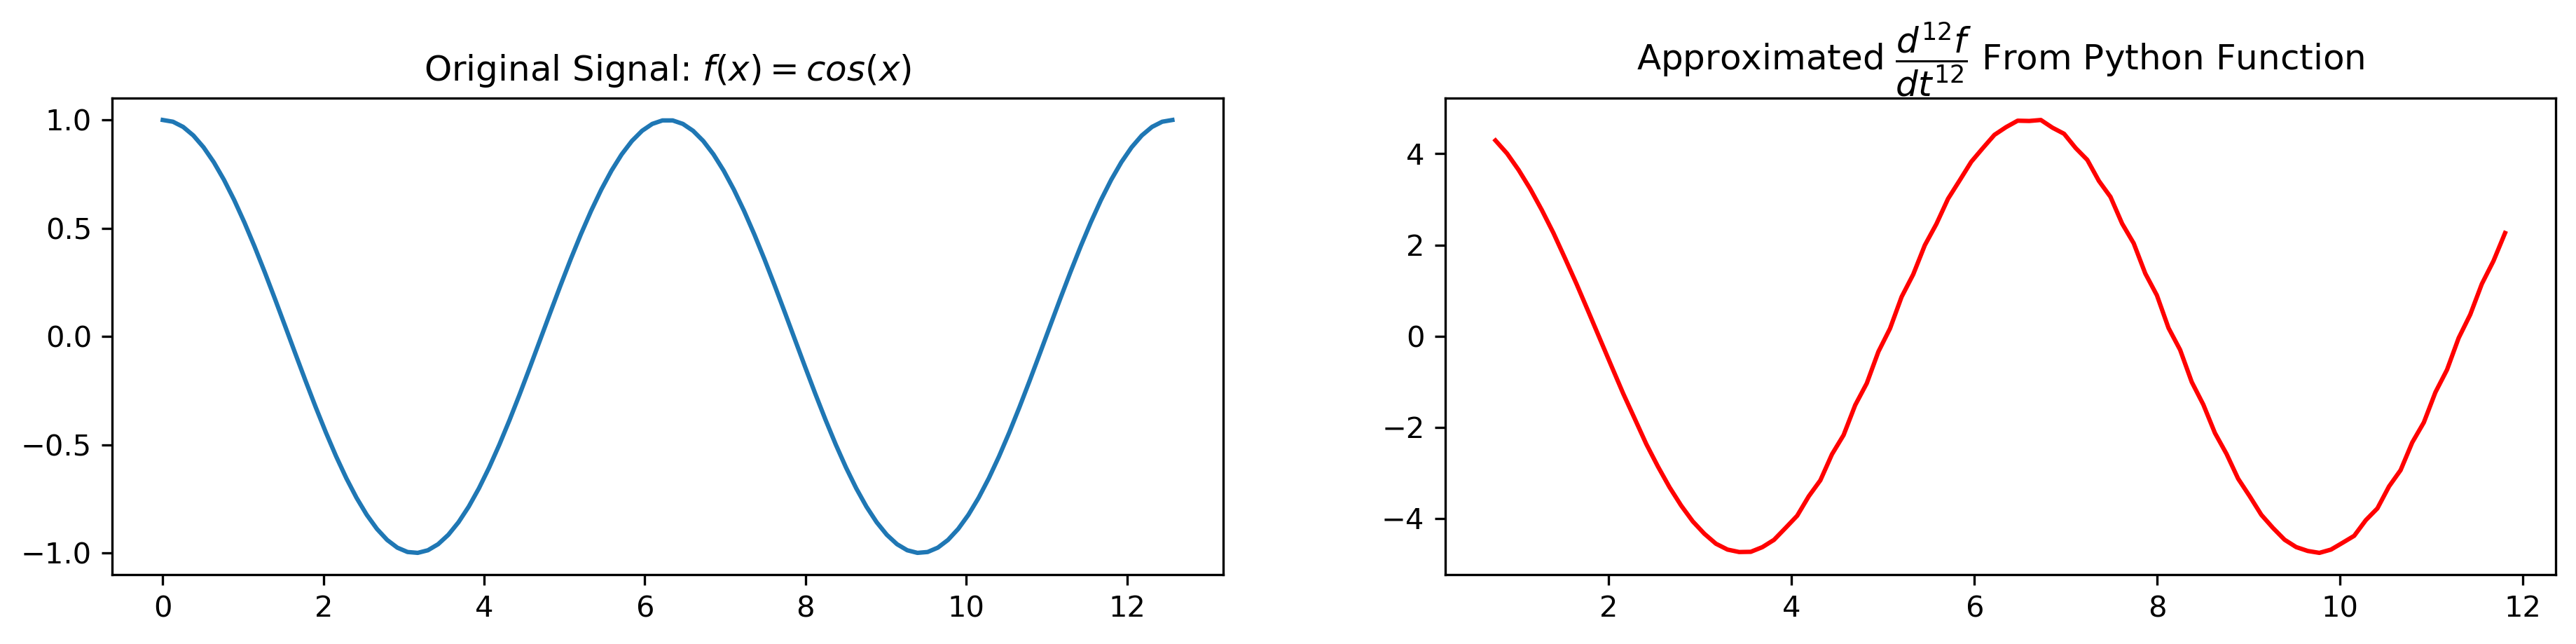

In [16]:
num_cycles= 2
x= np.linspace(0,2*pi*num_cycles, 100)
y= np.cos(x)
y_prime12 = compute_derivative(y,x[1]-x[0],12,2)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime12, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

If we use a larger or smaller number of samples or cycles, the function starts to break down. Through some trial and error, I found that the function "stabilizes" for the 12th derivative as long as the number of points is 25x the number of cycles:

##### 2 cycles, 12th derivative

Text(0.5, 1.0, 'Approximated $\\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

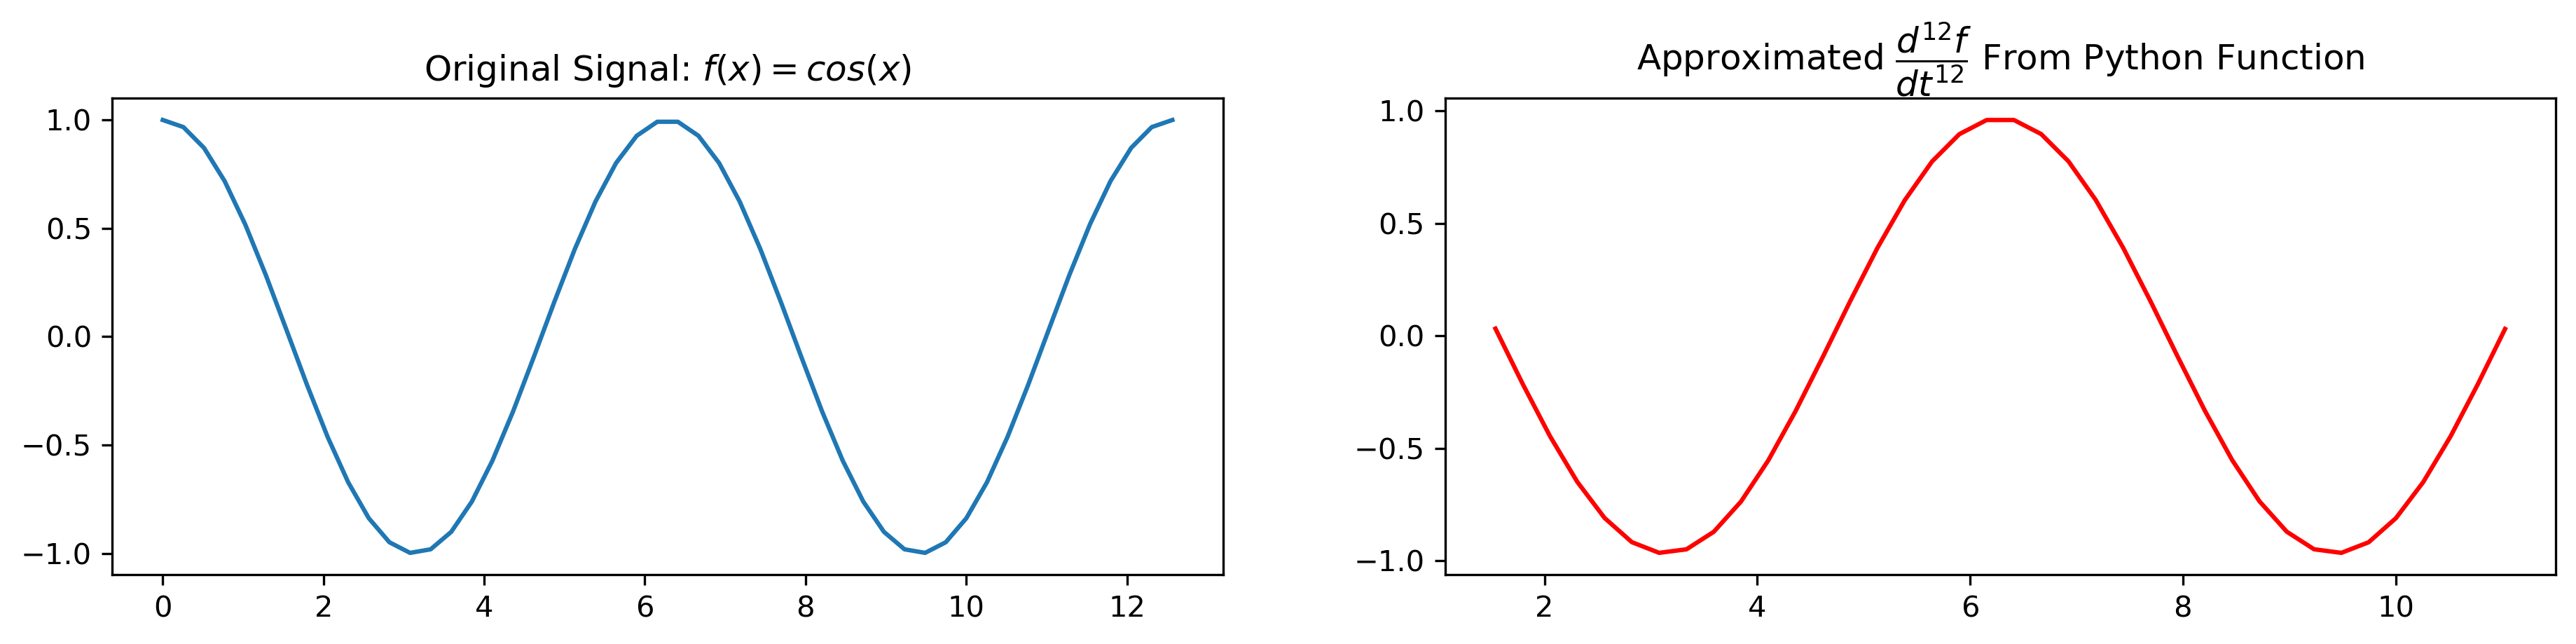

In [17]:
num_cycles= 2
x= np.linspace(0,2*pi*num_cycles, num_cycles*25)
y= np.cos(x)
y_prime12 = compute_derivative(y,x[1]-x[0],12,2)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime12, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

##### 4 cycles, 12th derivative

Text(0.5, 1.0, 'Approximated $\\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

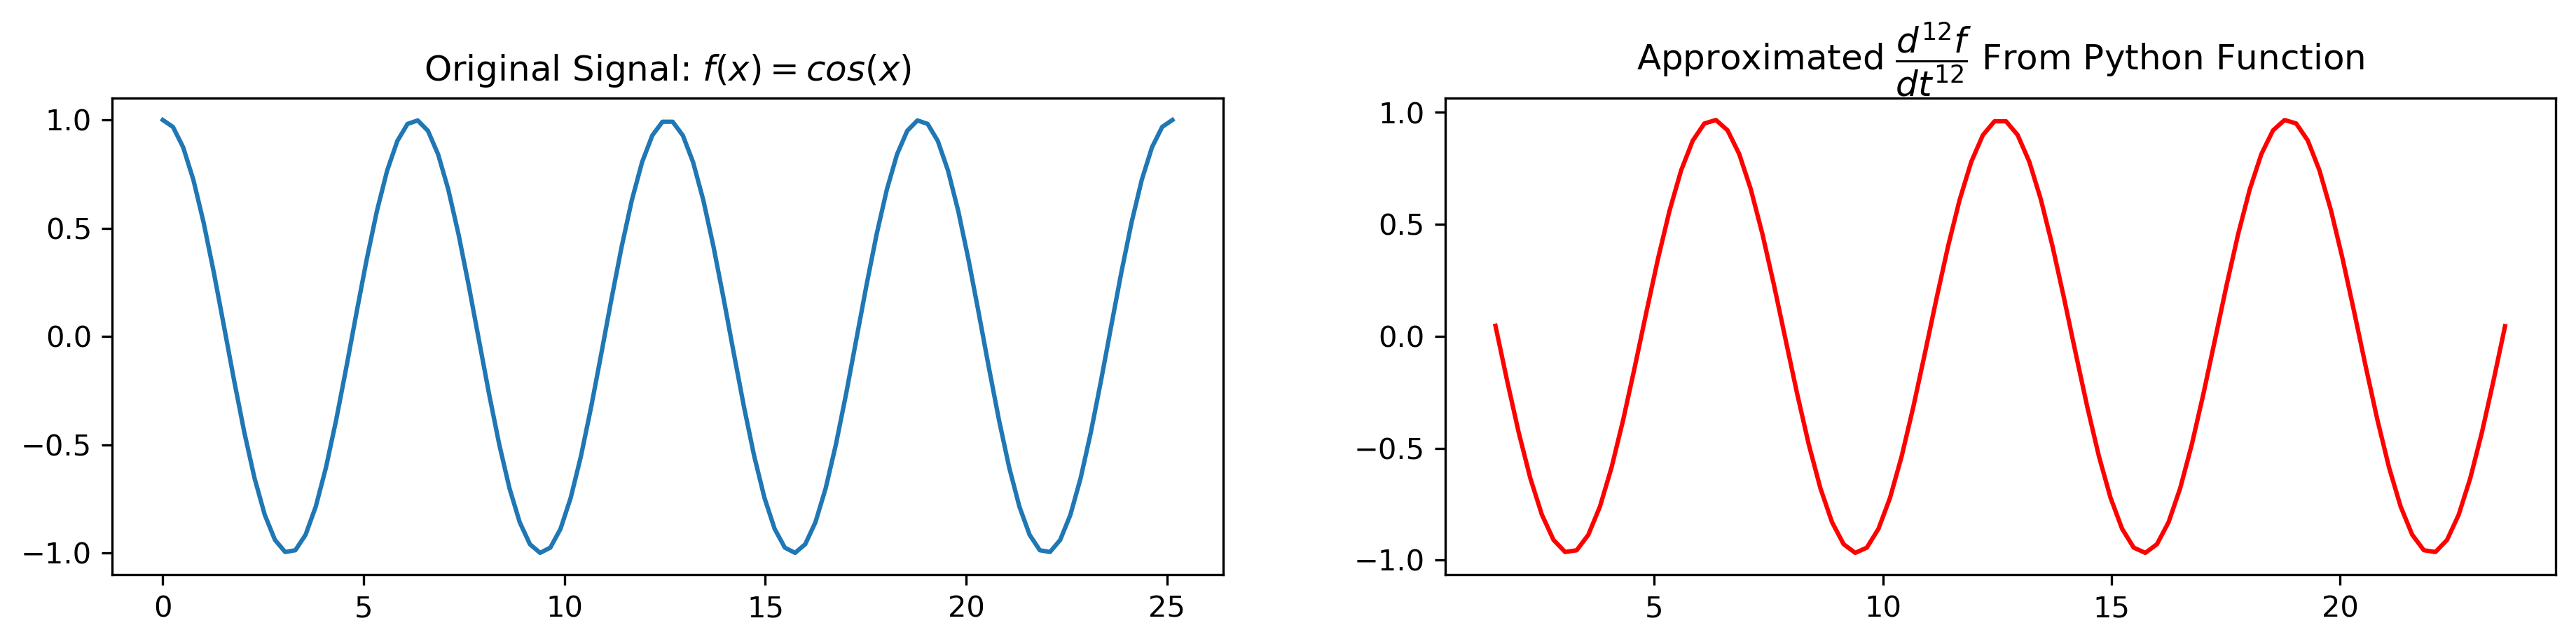

In [18]:
num_cycles= 4
x= np.linspace(0,2*pi*num_cycles, num_cycles*25)
y= np.cos(x)
y_prime12 = compute_derivative(y,x[1]-x[0],12,2)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime12, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

##### 8 cycles, 12th derivative

Text(0.5, 1.0, 'Approximated $\\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

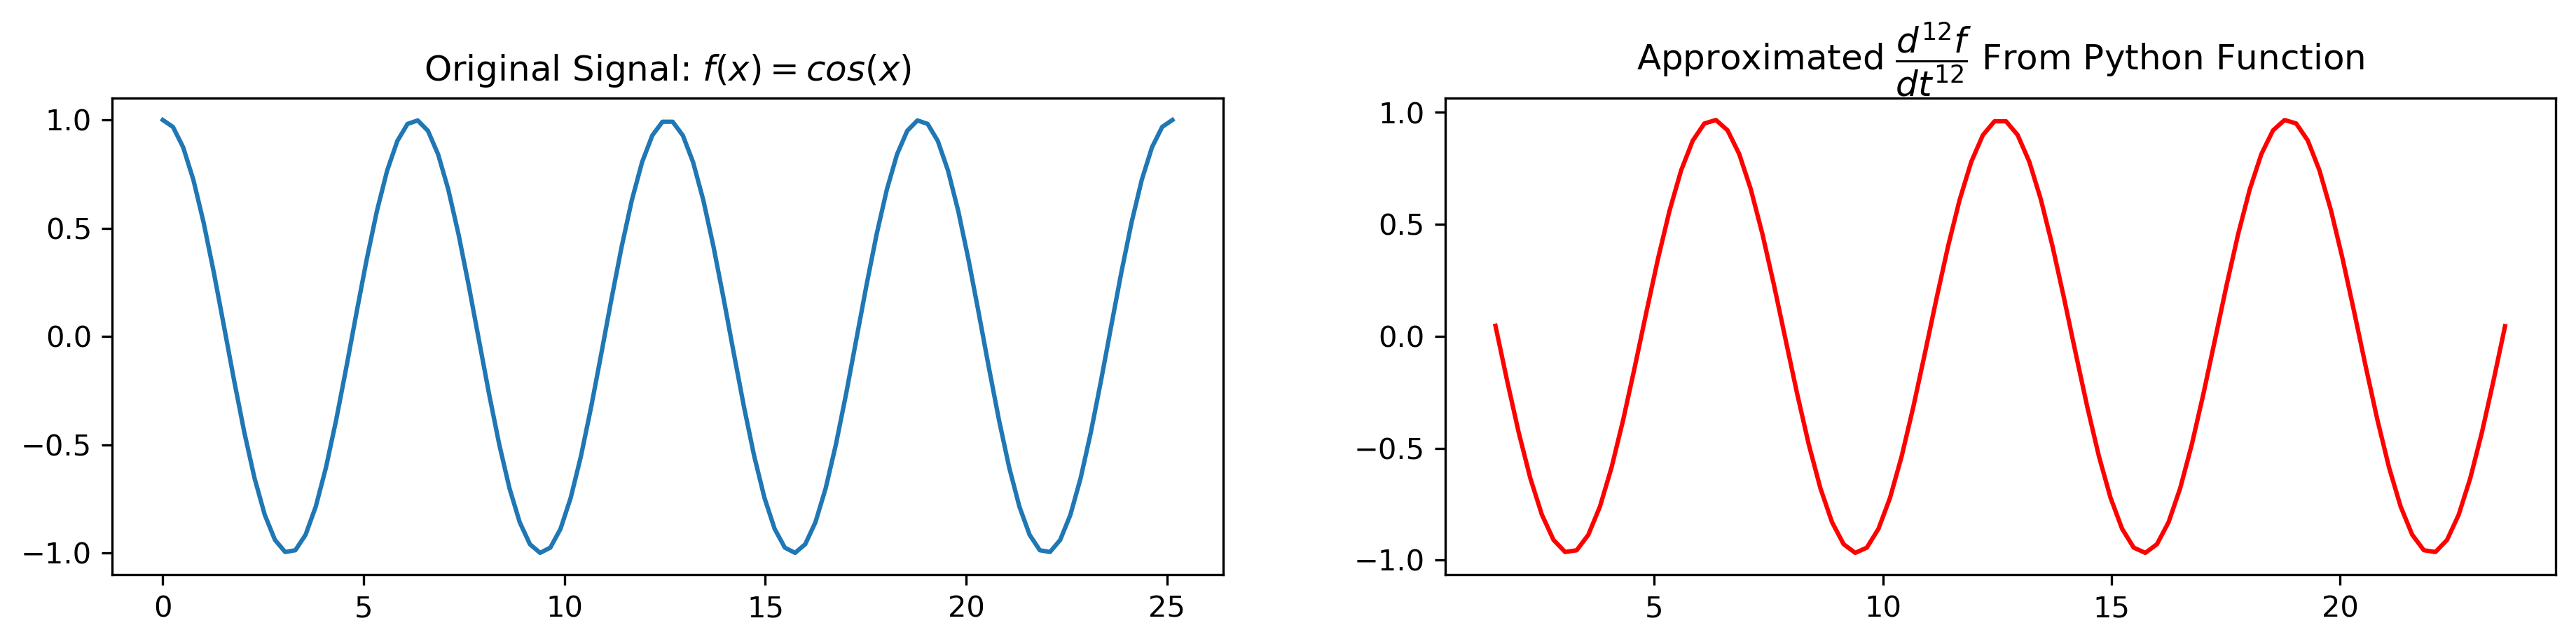

In [19]:
num_cycles= 4
x= np.linspace(0,2*pi*num_cycles, num_cycles*25)
y= np.cos(x)
y_prime12 = compute_derivative(y,x[1]-x[0],12,2)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime12, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^{12}f}{dt^{12}}$ From Python Function')

BUT, this doesn't hold if I bump up the number of derivatives:

##### 8 Cycles, 16th Derivative

Text(0.5, 1.0, 'Approximated $\\dfrac{d^{16}f}{dt^{16}}$ From Python Function')

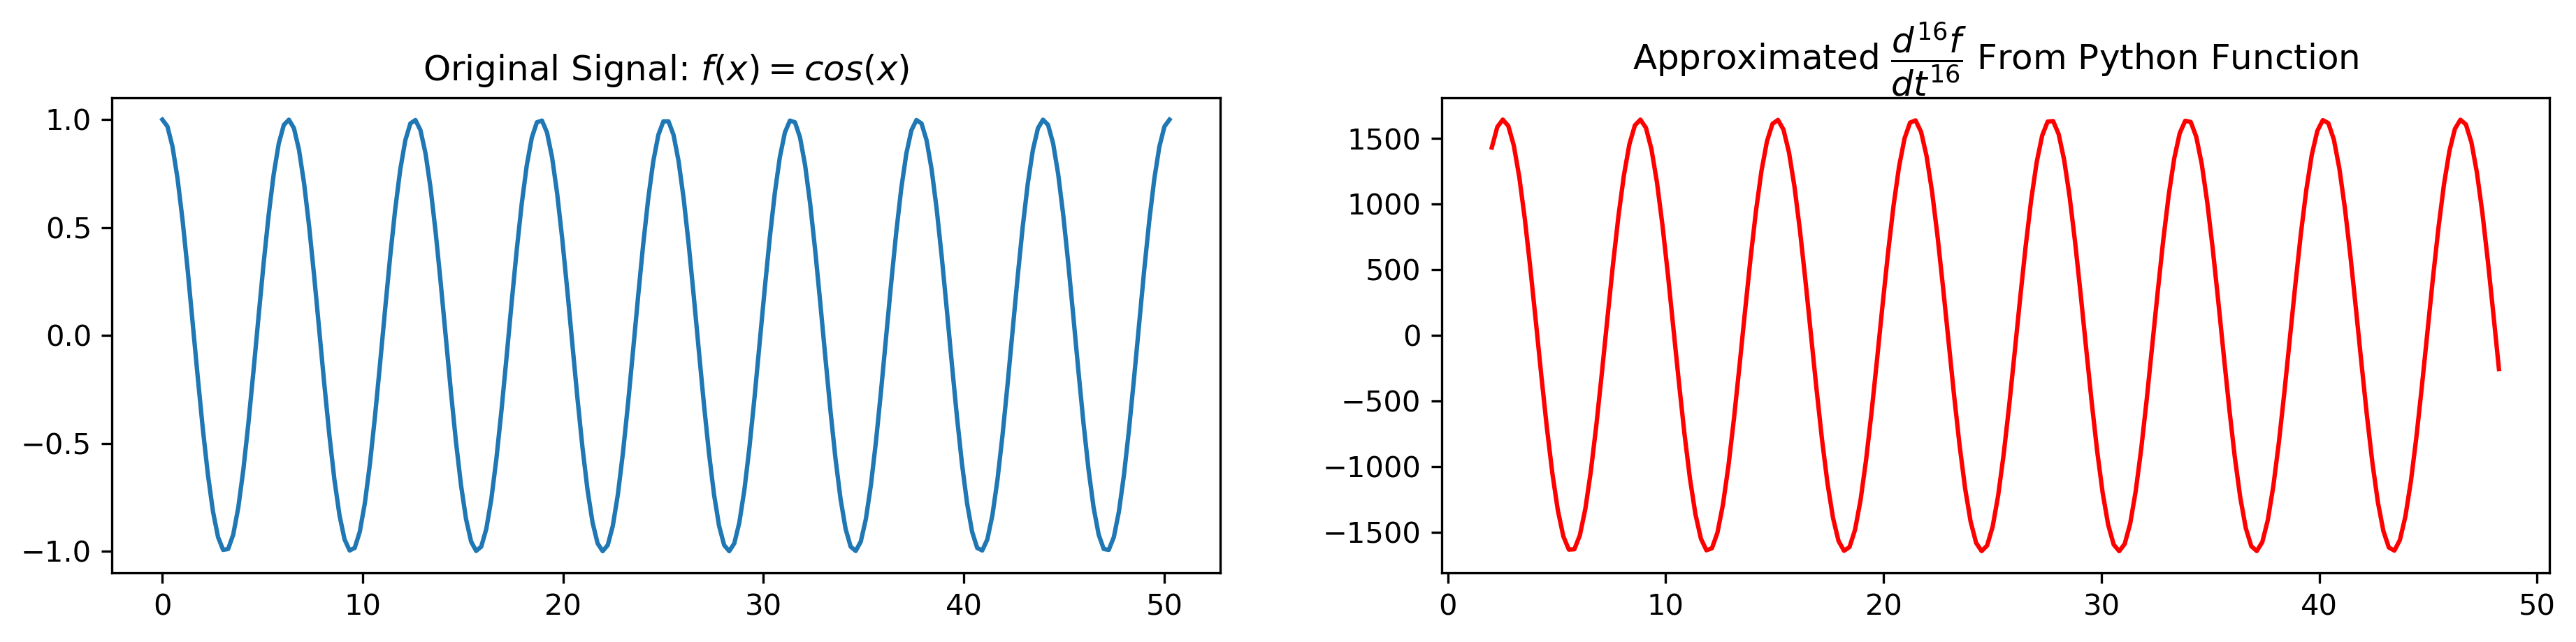

In [20]:
num_cycles= 8
x= np.linspace(0,2*pi*num_cycles, num_cycles*25)
y= np.cos(x)
y_prime12 = compute_derivative(y,x[1]-x[0],16,2)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime12, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^{16}f}{dt^{16}}$ From Python Function')

I'm interested in finding out _why_ there seems to be this relationship between the number of cycles and the number of data points that influences the accuracy of the approximation of the 12th derivative from the Python Function. Of course, there are definitely the round-off and trunkation errors, but there seems to be some relationship between the sampling rate, the number of cycles, and the accuracy of the function that I am not knowledgeable enough to explain. Is this coincidence or is there more to this? I'm sure someone has figured this out, but this is beyond my scope of knowledge. I'm far from being even remotely close to an expert in this space, nor do I have the math skills to figure something like this out in a reasonable amount of time. Therefore, I've got much more studying to do (unless someone is kind enough to also teach me more about this :) ).

Just as a final note for those who may be concerned, under the current conditions it seems as though the function "works well" up to the 13th derivative and an order of accuracy up to 2. Again, for most movement scientists and Kinesiology researchers this is well beyond what we would likely need in practice and I have confidence that this function can be used without any major practical concerns.

Text(0.5, 1.0, 'Approximated $\\dfrac{d^{13}f}{dt^{13}}$ From Python Function')

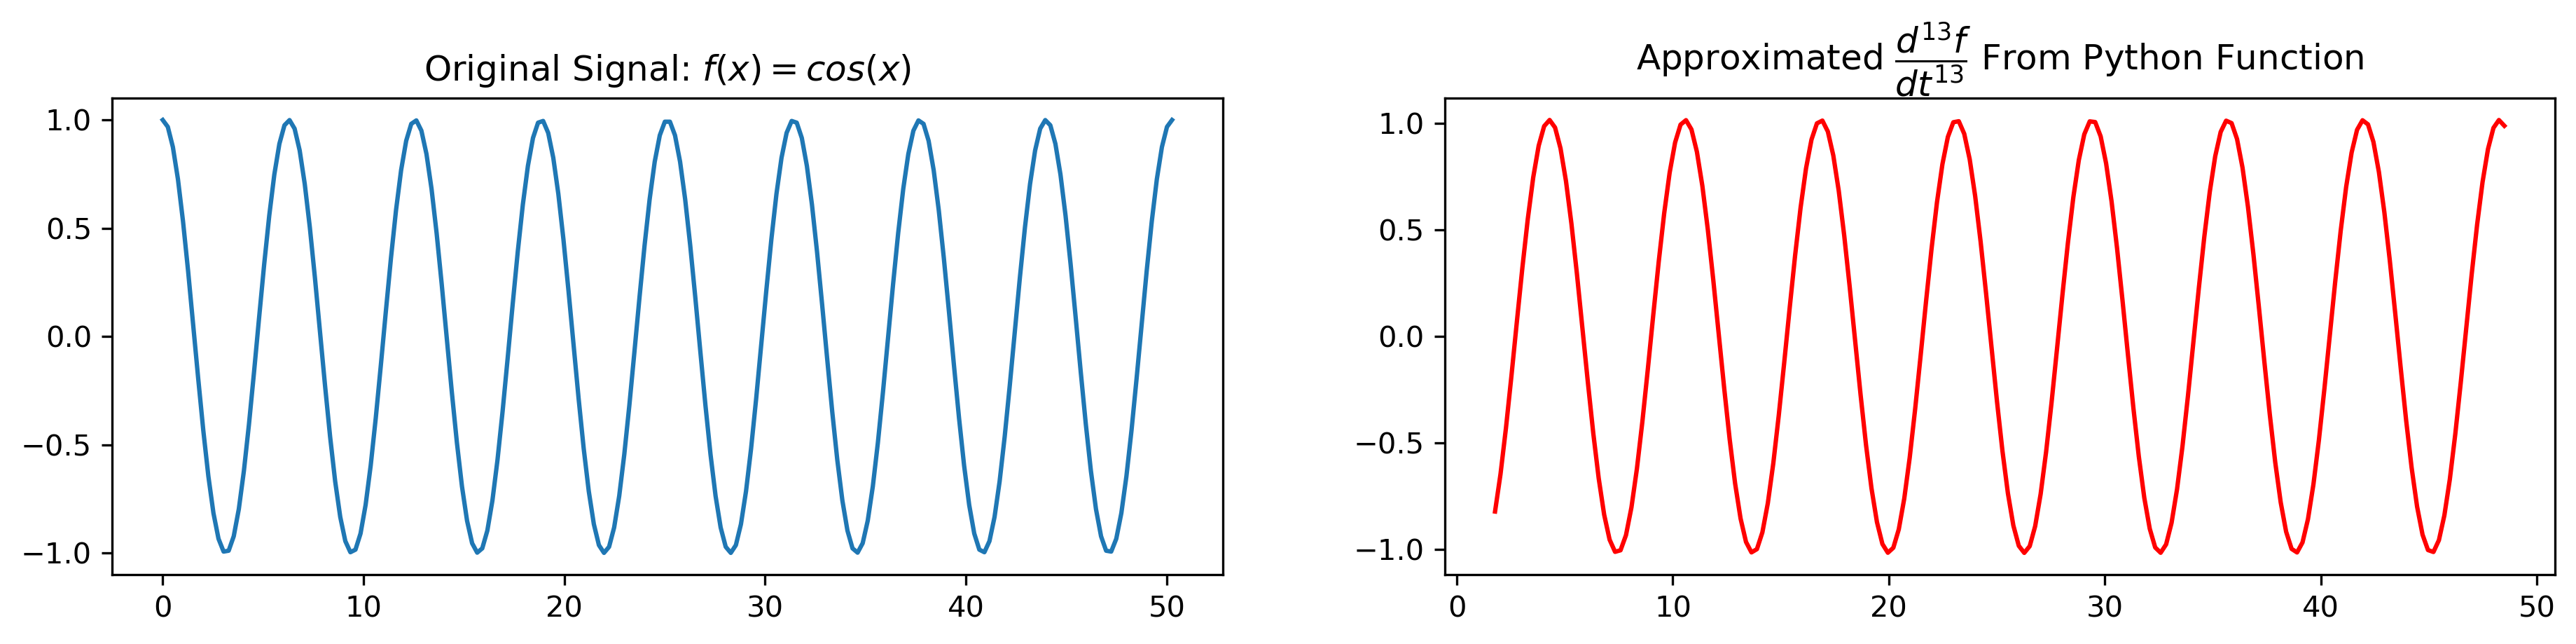

In [21]:
num_cycles= 8
x= np.linspace(0,2*pi*num_cycles, num_cycles*25)
y= np.cos(x)
y_prime12 = compute_derivative(y,x[1]-x[0],13,2)
fig, ax = plt.subplots(1,2, figsize= (15,3))
ax[0].plot(x,y)
ax[0].set_title('Original Signal: $f(x) = cos(x)$')
ax[1].plot(x,y_prime12, color= 'r')
ax[1].set_title(r'Approximated $\dfrac{d^{13}f}{dt^{13}}$ From Python Function')